
# Regression

In [1]:
# append path to the library
import sys, os
from os.path import dirname
p = dirname(os.getcwd())
sys.path.append(p)

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob, json
from sklearn.externals import joblib
from stochastic_optimizer.estimator import SGDRegressor, AdamRegressor, AdaGradRegressor
from stochastic_optimizer.estimator import RMSpropRegressor, AdaDeltaRegressor, VSGDRegressor
from stochastic_optimizer.framework import LearningCurveRegressor, GridSearch
from stochastic_optimizer.other import PlotCurves
from data import RegressionData

In [3]:
rd = RegressionData(
    var=10, mean=0, rate=0.1, prob=0.1, dist='normal', shape=(30000, 1000),
    c_var=10, c_mean=0.1, c_rate=0, c_dist=None, noise_var=1)
print(rd.X.shape, rd.coef_.shape, rd.y.shape)

(30000, 1000) (1000,) (30000,)


# Grid Search
- check the progress at "path/logger.log"
- "path" is the parameter of "GridSearch"

In [39]:
p = {'eta0': np.linspace(0.0001, 0.001, 20), 'power_t': [0.5, 1]}
p_0 = {'eta0': np.linspace(0.01, 0.8, 20)}
p_1 = {'eta0': np.linspace(0.01, 0.8, 20), 'var_w': np.linspace(0.01, 1, 20)}
p_2 = {'eps_': [10**i for i in np.linspace(-10, -1, 20)], 'rms':[True, False], 'var_w': np.linspace(0.01, 1, 20)}

setting = {'warm_start': True}

regressor = [
    ("SGD", SGDRegressor(**setting), p),
    ("AdaGrad", AdaGradRegressor(**setting), p_0),
    ("RMSprop", RMSpropRegressor(**setting), p_1),
    ("Adam", AdamRegressor(**setting), p_1),
    ("AdaDelta", AdaDeltaRegressor(**setting), p_2),
]

X_s, y_s = rd.X[0:10000], rd.y[0:10000]
path_gs = GridSearch(X_s, y_s, regressor, path='examples_result/grid_search/',
                     key="regression_gridsearching", scoring="r2")
print("result was saved: %s" % path_gs)

result was saved: examples_result/grid_search/regression_gridsearching


In [40]:
file = glob.glob("%s/*.pkl" % path_gs)
best_parameter = {}
for f in file:
    clf = joblib.load(f)    
    name = f.split("/")[-1].replace(".pkl", "")
    best_parameter[name] = clf.best_estimator_.get_params()
best_parameter

{'AdaDelta': {'alpha': 0.0001,
  'eps_': 0.011288378916846883,
  'fit_intercept': True,
  'loss': 'square',
  'momentum': 1,
  'n_jobs': 1,
  'penalty': 'l1',
  'rms': False,
  'var_w': 0.01,
  'warm_start': True},
 'AdaGrad': {'alpha': 0.0001,
  'eps_': 1e-08,
  'eta0': 0.80000000000000004,
  'fit_intercept': True,
  'loss': 'square',
  'momentum': 1,
  'n_jobs': 1,
  'penalty': 'l1',
  'warm_start': True},
 'Adam': {'alpha': 0.0001,
  'eps_': 1e-08,
  'eta0': 0.051578947368421058,
  'fit_intercept': True,
  'loss': 'square',
  'momentum': 1,
  'n_jobs': 1,
  'penalty': 'l1',
  'rms': True,
  'var_w': 0.06210526315789474,
  'warm_start': True},
 'RMSprop': {'alpha': 0.0001,
  'eps_': 1e-08,
  'eta0': 0.051578947368421058,
  'fit_intercept': True,
  'loss': 'square',
  'momentum': 1,
  'n_jobs': 1,
  'penalty': 'l1',
  'rms': True,
  'var_w': 0.06210526315789474,
  'warm_start': True},
 'SGD': {'alpha': 0.0001,
  'eta0': 0.001,
  'fit_intercept': False,
  'loss': 'square',
  'n_jobs': 

## Learning Models
- check the progress at "path/logger.log"
- "path" is the parameter of "LearningCurveClassifier"

In [41]:
setting = {"fit_intercept":False, "warm_start":True}
regressors = [
    ("SGD", SGDRegressor(**best_parameter["SGD"])),
    ("AdaGrad", AdaGradRegressor(**best_parameter["AdaGrad"])),
    ("RMSprop", RMSpropRegressor(**best_parameter["RMSprop"])),
    ("Adam", AdamRegressor(**best_parameter["Adam"])),
    ("AdaDelta", AdaDeltaRegressor(**best_parameter["AdaDelta"])),
    ("VSGD", VSGDRegressor(**setting)),
]

path_lc = LearningCurveRegressor(rd.X, rd.y_noise, regressors, path='examples_result/compare/', key="regression_simulation",
                                 rounds=2, split=50)

In [47]:
help(PlotCurves)

Help on class PlotCurves in module stochastic_optimizer.other.plot_curves:

class PlotCurves(builtins.object)
 |  Plot learning curve
 |  
 |   Parameters
 |  ----------
 |  yy: dict of error {algorithm_name:[error]}
 |  data_size: full datasize used in learning
 |  split: splitting number
 |  rounds: independent trial number
 |  data_path: where to save the figure
 |  
 |  Methods defined here:
 |  
 |  __init__(self, split, data_order, data_size, rounds, data_classes=1, remove=[])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  error(self, yy, fill_ci=True)
 |  
 |  sparsity(self, yy, fill_ci=True)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



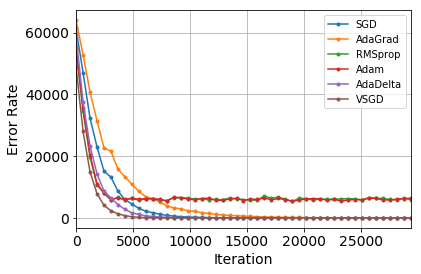

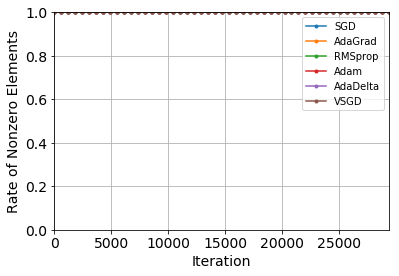

In [49]:
with open("%s/simulation_setting.json" % path_lc) as f:
    params = json.load(f)
with open("%s/error.json" % path_lc) as f:
    error = json.load(f)
with open("%s/nonzero.json" % path_lc) as f:
    nonzero = json.load(f)

pc = PlotCurves(**params)
fig = pc.error(error, fill_ci=False)
plt.rcParams['font.size'] = 14
plt.legend(loc="best", fontsize=10)
plt.savefig("%s/error.eps" % path_lc, bbox_inches="tight")
plt.savefig("%s/error.pdf" % path_lc, bbox_inches="tight", transparent=True)
plt.show()

fig = pc.sparsity(nonzero, fill_ci=False)
plt.rcParams['font.size'] = 14
plt.legend(loc="best", fontsize=10)
plt.savefig("%s/sparsity.eps" % path_lc, bbox_inches="tight")
plt.savefig("%s/sparsity.pdf" % path_lc, bbox_inches="tight", transparent=True)
plt.show()

# The way to see the learned model

In [44]:
file = glob.glob("%s/*.pkl" % path_lc)
for f in file:
    clf = joblib.load(f)
    name = f.split("/")[-1].replace(".pkl", "")
    print(name)
    print(clf)

VSGD
VSGDRegressor(alpha=0.0001, decay=False, fit_intercept=False, loss='square',
       momentum=1, n_jobs=1, penalty='l1', rms=True, var_w=1,
       warm_start=True)
Adam
AdamRegressor(alpha=0.0001, eps_=1e-08, eta0=0.051578947368421058,
       fit_intercept=True, loss='square', momentum=1, n_jobs=1,
       penalty='l1', rms=True, var_w=0.06210526315789474, warm_start=True)
AdaGrad
AdaGradRegressor(alpha=0.0001, eps_=1e-08, eta0=0.80000000000000004,
         fit_intercept=True, loss='square', momentum=1, n_jobs=1,
         penalty='l1', warm_start=True)
SGD
SGDRegressor(alpha=0.0001, eta0=0.001, fit_intercept=False, loss='square',
       n_jobs=1, penalty=None, power_t=0.5, warm_start=True)
AdaDelta2
AdaDeltaRegressor(alpha=0.0001, eps_=0.001, fit_intercept=False,
         loss='square', momentum=1, n_jobs=1, penalty='l1', rms=False,
         var_w=0.1, warm_start=True)
AdaDelta
AdaDeltaRegressor(alpha=0.0001, eps_=0.011288378916846883, fit_intercept=True,
         loss='square', mom